# VAE vs Heston Surface Comparison

Interactive notebook for comparing VAE-reconstructed volatility surfaces with Heston-calibrated surfaces.

**Prerequisites:**
1. Run `training_vae.ipynb` to train the VAE
2. Run `eval_vae.ipynb` to generate VAE surfaces
3. Run `heston_calibration.ipynb` to generate Heston surfaces

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from pathlib import Path

%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')

# Create output directory
OUTPUT_DIR = Path("../../artifacts/comparison")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

## 1. Load Surfaces

In [2]:
# Paths
VAE_DIR = Path("../../artifacts/eval/surfaces")
HESTON_DIR = Path("../../data/processed/heston/surfaces")
TICKER = "AAPL"

In [3]:
# Load VAE surfaces
vae_surfaces = np.load(VAE_DIR / "vae_surfaces.npy")
market_surfaces = np.load(VAE_DIR / "market_surfaces.npy")
vae_dates = pd.to_datetime(pd.read_csv(VAE_DIR / "vae_surface_dates.csv")["date"])

with open(VAE_DIR / "grid_spec.json") as f:
    grid_spec = json.load(f)

print(f"VAE surfaces:    {vae_surfaces.shape}")
print(f"Market surfaces: {market_surfaces.shape}")
print(f"VAE dates: {vae_dates[0].date()} to {vae_dates.iloc[-1].date()} ({len(vae_dates)} dates)")

VAE surfaces:    (244, 2, 11, 17)
Market surfaces: (244, 2, 11, 17)
VAE dates: 2024-09-10 to 2025-08-29 (244 dates)


In [4]:
# Load Heston surfaces
heston_surfaces = np.load(HESTON_DIR / f"{TICKER}_heston_surfaces.npy")
heston_dates = pd.to_datetime(pd.read_csv(HESTON_DIR / f"{TICKER}_heston_surface_dates.csv")["date"])

print(f"Heston surfaces: {heston_surfaces.shape}")
print(f"Heston dates: {heston_dates[0].date()} to {heston_dates.iloc[-1].date()} ({len(heston_dates)} dates)")

Heston surfaces: (244, 2, 11, 17)
Heston dates: 2024-09-10 to 2025-08-29 (244 dates)


## 2. Align Surfaces by Date

In [5]:
# Find common dates
vae_date_set = set(vae_dates.dt.date)
heston_date_set = set(heston_dates.dt.date)
common_dates = sorted(vae_date_set & heston_date_set)

print(f"VAE dates:      {len(vae_dates)}")
print(f"Heston dates:   {len(heston_dates)}")
print(f"Common dates:   {len(common_dates)}")
print(f"\nDate range: {common_dates[0]} to {common_dates[-1]}")

VAE dates:      244
Heston dates:   244
Common dates:   244

Date range: 2024-09-10 to 2025-08-29


In [6]:
# Create aligned arrays
vae_mask = [d in common_dates for d in vae_dates.dt.date]
heston_mask = [d in common_dates for d in heston_dates.dt.date]

vae_aligned = vae_surfaces[vae_mask]
market_aligned = market_surfaces[vae_mask]
heston_aligned = heston_surfaces[heston_mask]
aligned_dates = vae_dates[vae_mask]

print(f"Aligned shapes:")
print(f"  VAE:    {vae_aligned.shape}")
print(f"  Market: {market_aligned.shape}")
print(f"  Heston: {heston_aligned.shape}")

Aligned shapes:
  VAE:    (244, 2, 11, 17)
  Market: (244, 2, 11, 17)
  Heston: (244, 2, 11, 17)


## 3. Compute Comparison Metrics

In [7]:
def compute_metrics(surfaces_a, surfaces_b):
    """Compute MSE, MAE, RMSE between two surface arrays, ignoring NaN values."""
    errors = surfaces_a - surfaces_b
    abs_errors = np.abs(errors)
    sq_errors = errors ** 2
    
    # Count valid (non-NaN) comparisons
    valid_count = np.sum(~np.isnan(errors))
    total_count = errors.size
    
    return {
        "mse": float(np.nanmean(sq_errors)),
        "mae": float(np.nanmean(abs_errors)),
        "rmse": float(np.sqrt(np.nanmean(sq_errors))),
        "max_error": float(np.nanmax(abs_errors)),
        "valid_pct": float(valid_count / total_count * 100),
    }

In [8]:
# VAE vs Market
vae_metrics = compute_metrics(vae_aligned, market_aligned)
print("VAE vs Market (reconstruction quality):")
print(f"  MAE:  {vae_metrics['mae']:.6f} ({vae_metrics['mae']*100:.2f}%)")
print(f"  RMSE: {vae_metrics['rmse']:.6f}")

# Heston vs Market
heston_metrics = compute_metrics(heston_aligned, market_aligned)
print("\nHeston vs Market (calibration quality):")
print(f"  MAE:  {heston_metrics['mae']:.6f} ({heston_metrics['mae']*100:.2f}%)")
print(f"  RMSE: {heston_metrics['rmse']:.6f}")
print(f"  Valid comparisons: {heston_metrics['valid_pct']:.1f}% (NaN values skipped)")

# VAE vs Heston
direct_metrics = compute_metrics(vae_aligned, heston_aligned)
print("\nVAE vs Heston (direct difference):")
print(f"  MAE:  {direct_metrics['mae']:.6f}")
print(f"  RMSE: {direct_metrics['rmse']:.6f}")

VAE vs Market (reconstruction quality):
  MAE:  0.022585 (2.26%)
  RMSE: 0.032240

Heston vs Market (calibration quality):
  MAE:  0.046069 (4.61%)
  RMSE: 0.061711
  Valid comparisons: 93.6% (NaN values skipped)

VAE vs Heston (direct difference):
  MAE:  0.047420
  RMSE: 0.062765


In [9]:
# Summary
print("=" * 50)
if vae_metrics['mae'] < heston_metrics['mae']:
    improvement = (heston_metrics['mae'] - vae_metrics['mae']) / heston_metrics['mae'] * 100
    print(f"WINNER: VAE (MAE {improvement:.1f}% lower than Heston)")
else:
    improvement = (vae_metrics['mae'] - heston_metrics['mae']) / vae_metrics['mae'] * 100
    print(f"WINNER: Heston (MAE {improvement:.1f}% lower than VAE)")
print("=" * 50)

WINNER: VAE (MAE 51.0% lower than Heston)


## 4. Error Heatmaps

In [10]:
# Mean absolute error per cell (using nanmean to handle Heston NaNs)
vae_error_map = np.nanmean(np.abs(vae_aligned - market_aligned), axis=0)
heston_error_map = np.nanmean(np.abs(heston_aligned - market_aligned), axis=0)

days_grid = np.array(grid_spec["days_grid"])
delta_grid = np.array(grid_spec["delta_grid"])
cp_order = grid_spec["cp_order"]

# Count NaN positions in Heston
nan_count = np.sum(np.isnan(heston_aligned))
nan_pct = nan_count / heston_aligned.size * 100
print(f"Note: Heston has {nan_count:,} NaN values ({nan_pct:.1f}%) - these are skipped in comparisons")

Note: Heston has 5,868 NaN values (6.4%) - these are skipped in comparisons


C:\Users\Admin\AppData\Local\Temp\ipykernel_13996\2977055977.py:3: RuntimeWarning: Mean of empty slice
  heston_error_map = np.nanmean(np.abs(heston_aligned - market_aligned), axis=0)


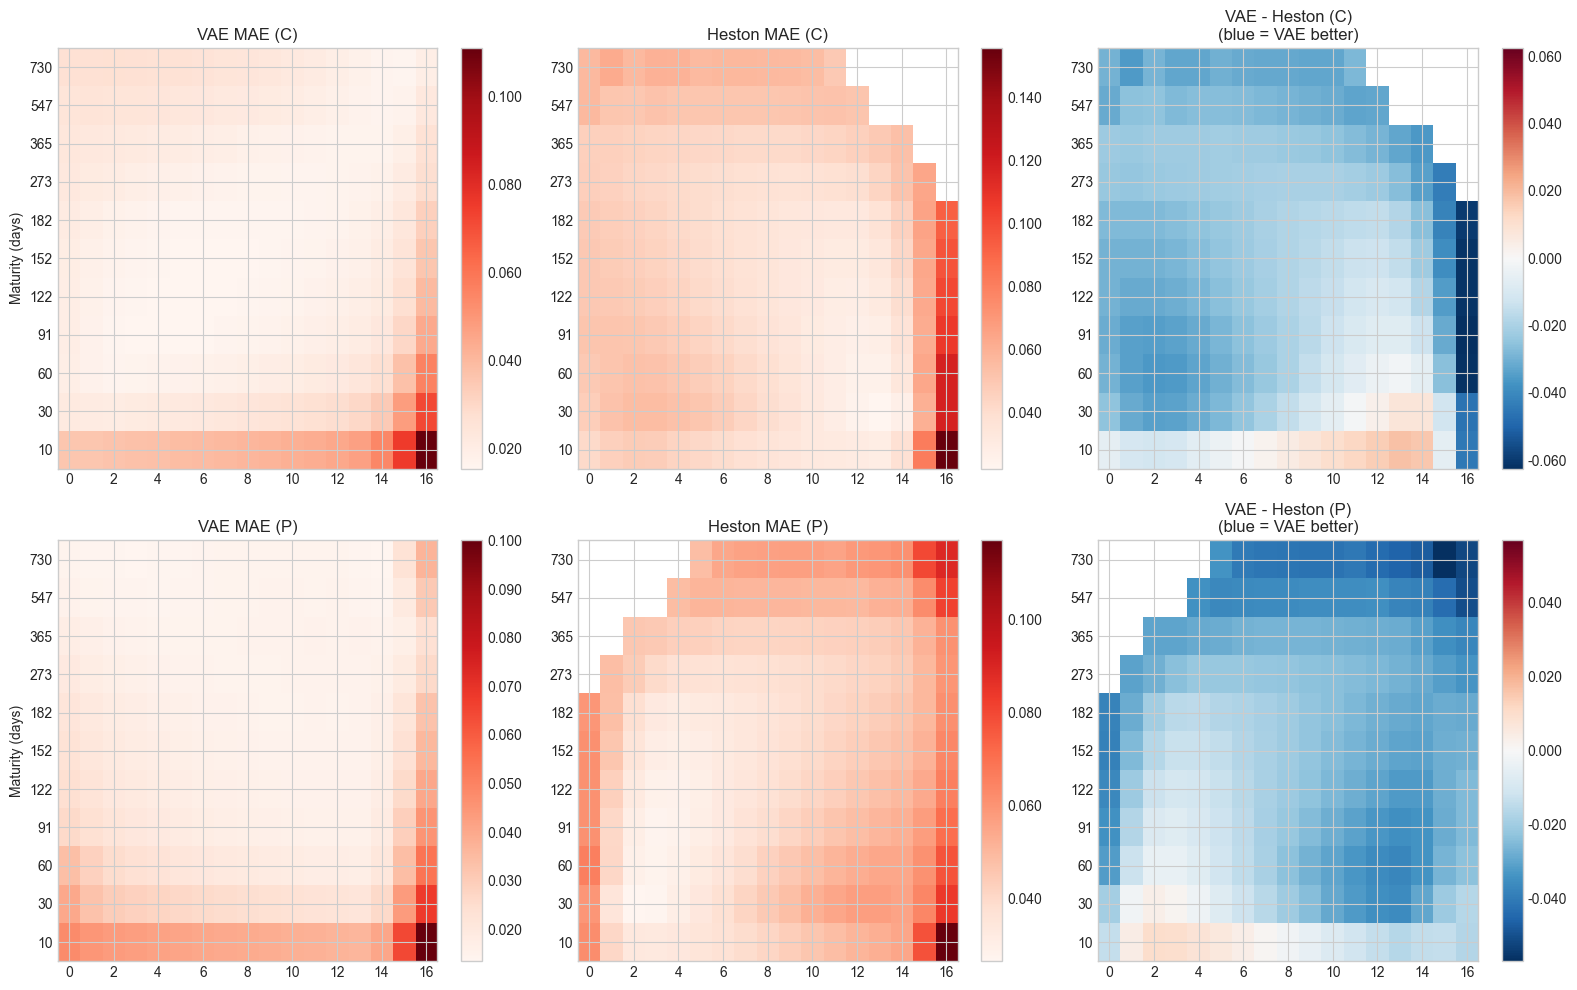

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

for c, cp in enumerate(cp_order):
    # VAE error
    im1 = axes[c, 0].imshow(vae_error_map[c], aspect="auto", origin="lower", cmap="Reds")
    axes[c, 0].set_title(f"VAE MAE ({cp})")
    axes[c, 0].set_ylabel("Maturity (days)")
    axes[c, 0].set_yticks(range(len(days_grid)))
    axes[c, 0].set_yticklabels([int(d) for d in days_grid])
    plt.colorbar(im1, ax=axes[c, 0], format="%.3f")
    
    # Heston error
    im2 = axes[c, 1].imshow(heston_error_map[c], aspect="auto", origin="lower", cmap="Reds")
    axes[c, 1].set_title(f"Heston MAE ({cp})")
    axes[c, 1].set_yticks(range(len(days_grid)))
    axes[c, 1].set_yticklabels([int(d) for d in days_grid])
    plt.colorbar(im2, ax=axes[c, 1], format="%.3f")
    
    # Difference (VAE - Heston)
    diff = vae_error_map[c] - heston_error_map[c]
    vmax = max(np.nanmax(np.abs(diff)), 0.001)  # Handle NaN with nanmax
    im3 = axes[c, 2].imshow(diff, aspect="auto", origin="lower", cmap="RdBu_r", vmin=-vmax, vmax=vmax)
    axes[c, 2].set_title(f"VAE - Heston ({cp})\n(blue = VAE better)")
    axes[c, 2].set_yticks(range(len(days_grid)))
    axes[c, 2].set_yticklabels([int(d) for d in days_grid])
    plt.colorbar(im3, ax=axes[c, 2], format="%.3f")

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "error_heatmaps.png", dpi=150)
plt.show()

## 5. Error Time Series

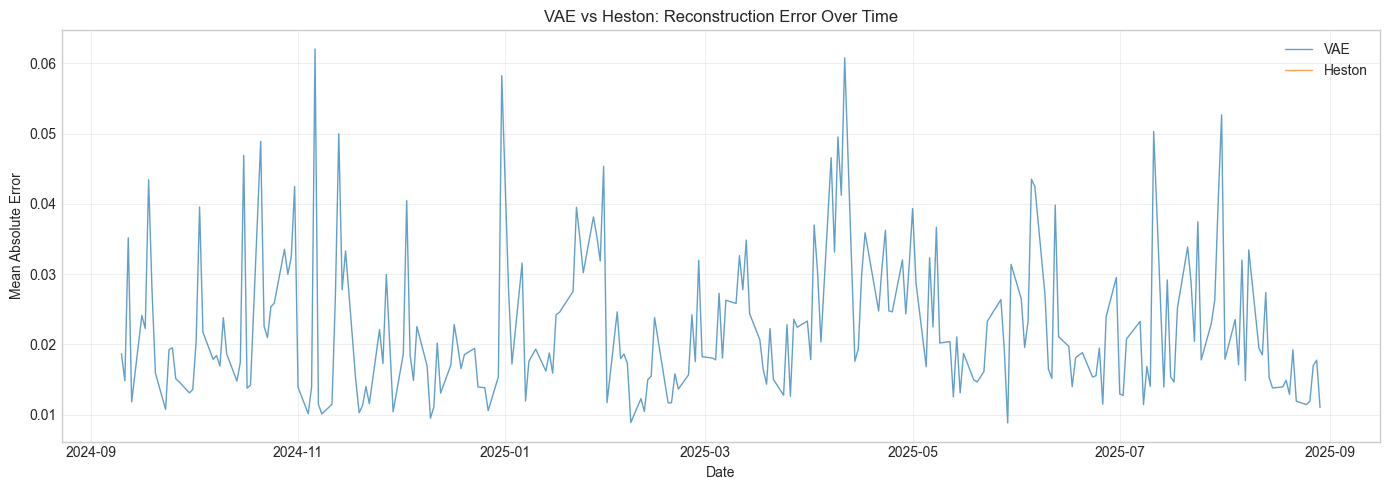

In [12]:
# Compute MAE per date
vae_mae_ts = np.abs(vae_aligned - market_aligned).mean(axis=(1, 2, 3))
heston_mae_ts = np.abs(heston_aligned - market_aligned).mean(axis=(1, 2, 3))

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(aligned_dates, vae_mae_ts, label="VAE", alpha=0.7, linewidth=1)
ax.plot(aligned_dates, heston_mae_ts, label="Heston", alpha=0.7, linewidth=1)
ax.set_xlabel("Date")
ax.set_ylabel("Mean Absolute Error")
ax.set_title("VAE vs Heston: Reconstruction Error Over Time")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "error_timeseries.png", dpi=150)
plt.show()

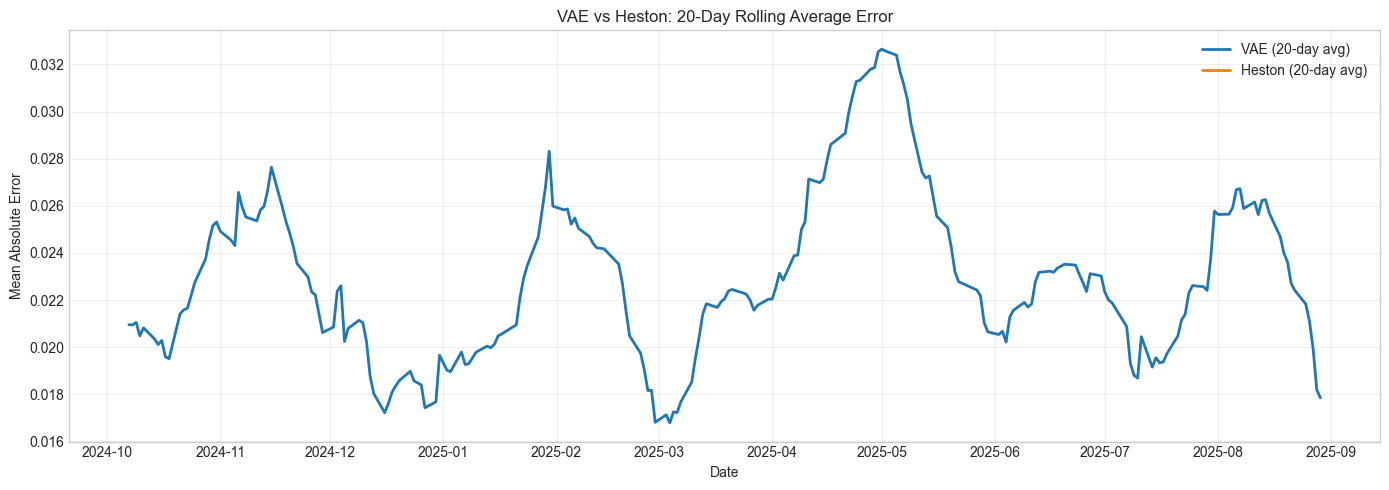

In [13]:
# Rolling average
window = 20

vae_rolling = pd.Series(vae_mae_ts).rolling(window).mean()
heston_rolling = pd.Series(heston_mae_ts).rolling(window).mean()

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(aligned_dates, vae_rolling, label=f"VAE ({window}-day avg)", linewidth=2)
ax.plot(aligned_dates, heston_rolling, label=f"Heston ({window}-day avg)", linewidth=2)
ax.set_xlabel("Date")
ax.set_ylabel("Mean Absolute Error")
ax.set_title(f"VAE vs Heston: {window}-Day Rolling Average Error")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Sample Surface Comparisons

In [14]:
def plot_surface_comparison(idx):
    """Plot Market, VAE, and Heston surfaces for a given index."""
    date_str = str(aligned_dates.iloc[idx].date())
    
    fig, axes = plt.subplots(2, 4, figsize=(18, 10))
    
    for c, cp in enumerate(cp_order):
        # Market
        im0 = axes[c, 0].imshow(market_aligned[idx, c], aspect="auto", origin="lower", cmap="viridis")
        axes[c, 0].set_title(f"Market ({cp})")
        axes[c, 0].set_ylabel("Maturity")
        plt.colorbar(im0, ax=axes[c, 0], format="%.3f")
        
        # VAE
        im1 = axes[c, 1].imshow(vae_aligned[idx, c], aspect="auto", origin="lower", cmap="viridis")
        axes[c, 1].set_title(f"VAE ({cp})")
        plt.colorbar(im1, ax=axes[c, 1], format="%.3f")
        
        # Heston
        im2 = axes[c, 2].imshow(heston_aligned[idx, c], aspect="auto", origin="lower", cmap="viridis")
        axes[c, 2].set_title(f"Heston ({cp})")
        plt.colorbar(im2, ax=axes[c, 2], format="%.3f")
        
        # Error bars
        vae_mae = np.abs(vae_aligned[idx, c] - market_aligned[idx, c]).mean()
        heston_mae = np.abs(heston_aligned[idx, c] - market_aligned[idx, c]).mean()
        
        axes[c, 3].bar(["VAE", "Heston"], [vae_mae, heston_mae], color=["blue", "orange"])
        axes[c, 3].set_ylabel("MAE")
        axes[c, 3].set_title(f"Error ({cp})")
    
    fig.suptitle(f"Surface Comparison - {date_str}", fontsize=14)
    plt.tight_layout()
    plt.show()

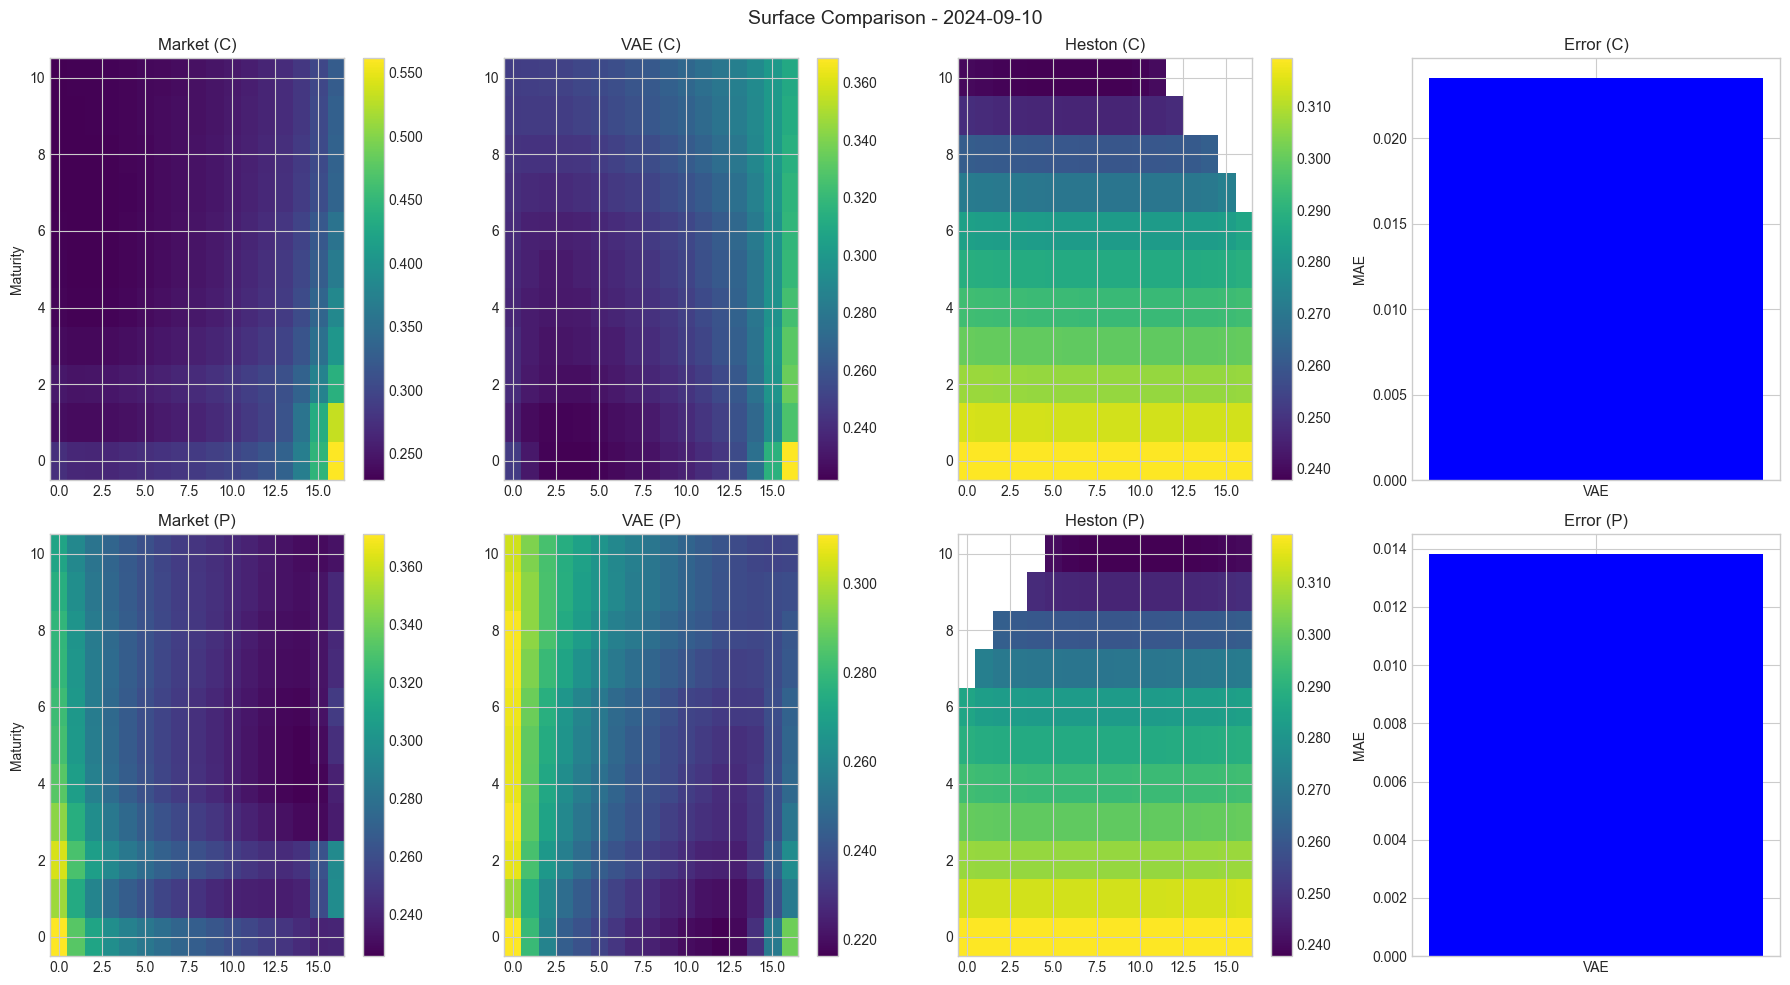

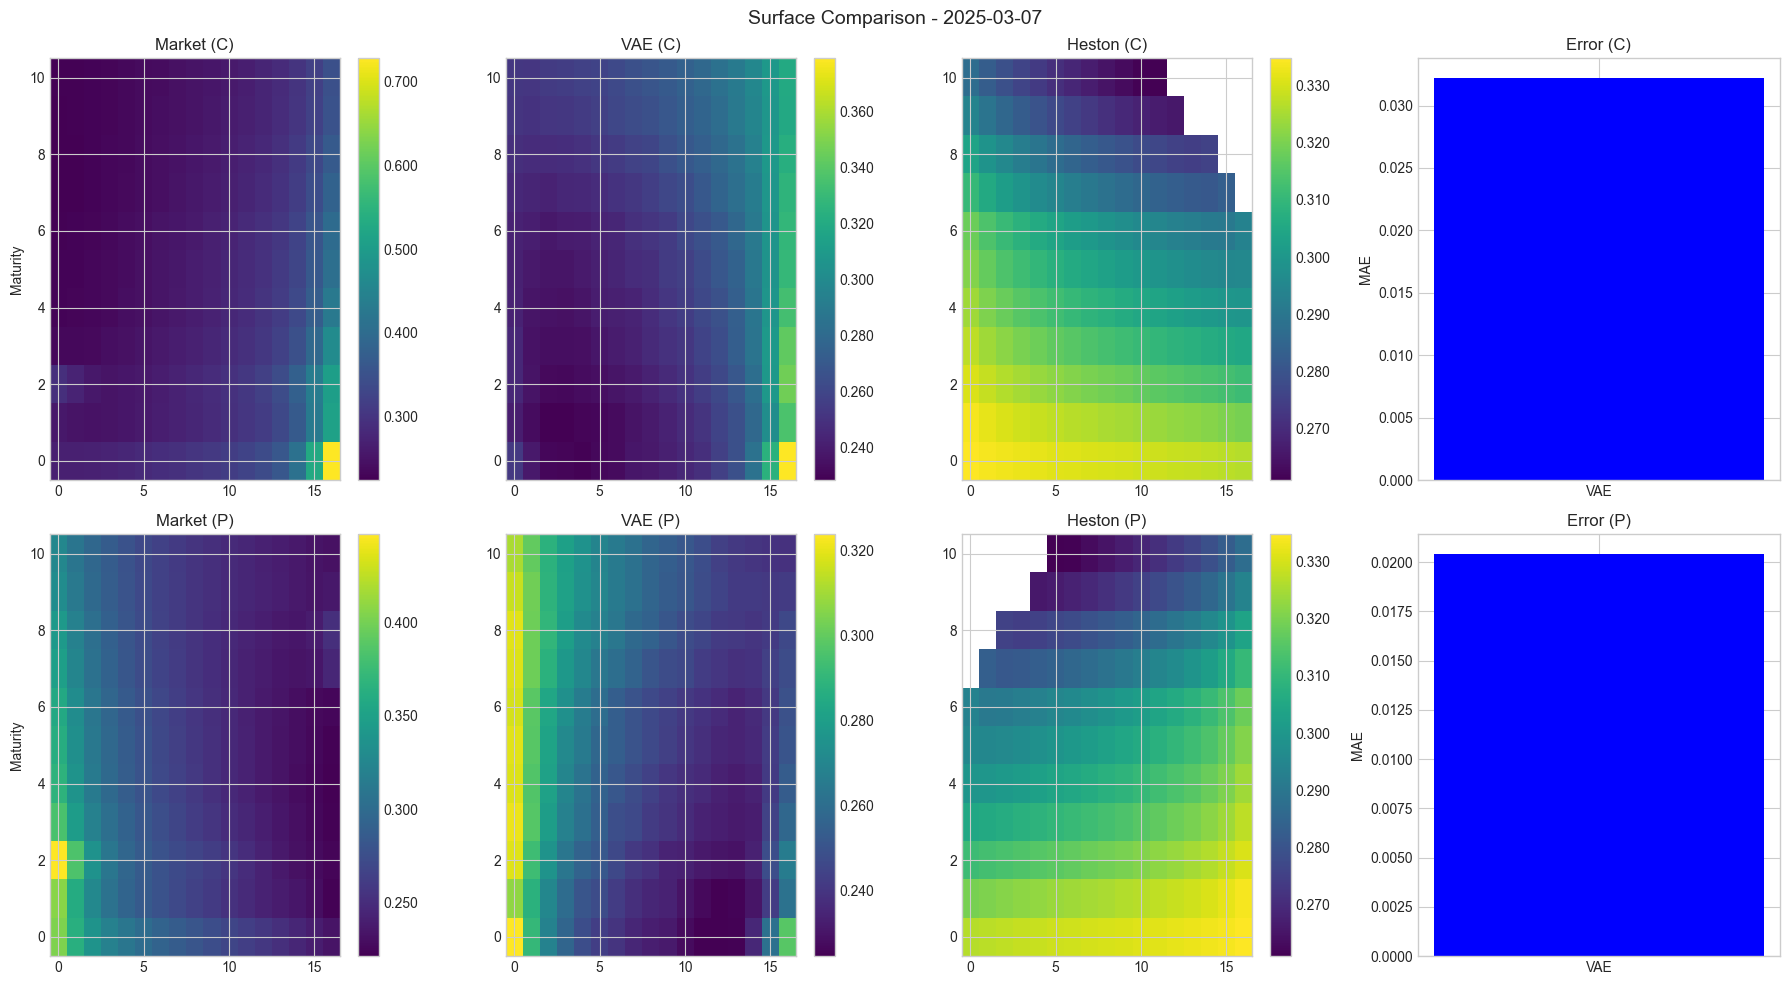

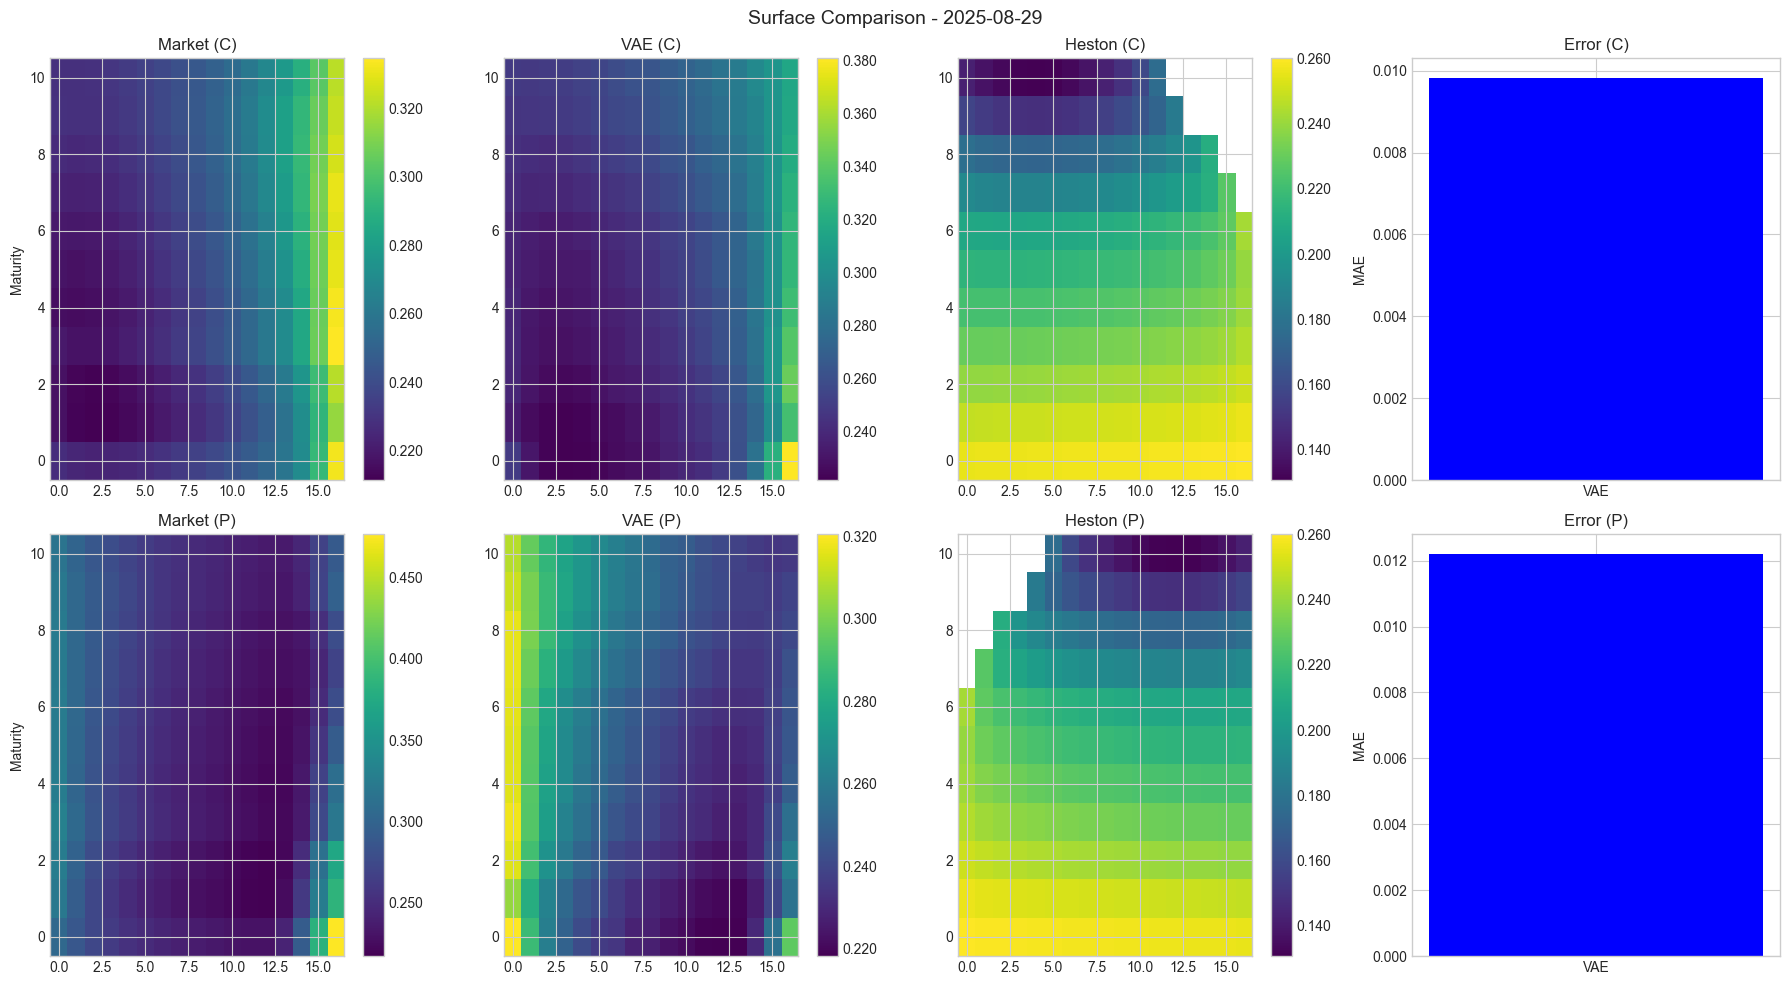

In [15]:
# Plot first, middle, and last samples
sample_indices = [0, len(aligned_dates)//2, len(aligned_dates)-1]

for idx in sample_indices:
    plot_surface_comparison(idx)

## 7. Per-Cell Analysis

In [16]:
# Find where each method performs best
vae_better_mask = vae_error_map < heston_error_map

for c, cp in enumerate(cp_order):
    n_cells = vae_better_mask[c].size
    n_vae_better = vae_better_mask[c].sum()
    
    print(f"{cp}: VAE better in {n_vae_better}/{n_cells} cells ({100*n_vae_better/n_cells:.1f}%)")

C: VAE better in 164/187 cells (87.7%)
P: VAE better in 166/187 cells (88.8%)


In [17]:
# Breakdown by maturity
print("\nMAE by maturity:")
print(f"{'Days':<8} {'VAE':<12} {'Heston':<12} {'Winner':<10}")
print("-" * 42)

for d, days in enumerate(days_grid):
    vae_mae = np.abs(vae_aligned[:, :, d, :] - market_aligned[:, :, d, :]).mean()
    heston_mae = np.abs(heston_aligned[:, :, d, :] - market_aligned[:, :, d, :]).mean()
    winner = "VAE" if vae_mae < heston_mae else "Heston"
    print(f"{int(days):<8} {vae_mae:.6f}     {heston_mae:.6f}     {winner}")


MAE by maturity:
Days     VAE          Heston       Winner    
------------------------------------------
10       0.046277     0.048703     VAE
30       0.029312     0.046933     VAE
60       0.023393     0.046152     VAE
91       0.020318     0.043921     VAE
122      0.019232     0.042801     VAE
152      0.018462     0.042566     VAE
182      0.018008     0.042575     VAE
273      0.017622     nan     Heston
365      0.017744     nan     Heston
547      0.018635     nan     Heston
730      0.019435     nan     Heston


In [18]:
# Breakdown by delta
print("\nMAE by delta:")
print(f"{'Delta':<8} {'VAE':<12} {'Heston':<12} {'Winner':<10}")
print("-" * 42)

for i, delta in enumerate(delta_grid):
    vae_mae = np.abs(vae_aligned[:, :, :, i] - market_aligned[:, :, :, i]).mean()
    heston_mae = np.abs(heston_aligned[:, :, :, i] - market_aligned[:, :, :, i]).mean()
    winner = "VAE" if vae_mae < heston_mae else "Heston"
    print(f"{delta:.2f}     {vae_mae:.6f}     {heston_mae:.6f}     {winner}")


MAE by delta:
Delta    VAE          Heston       Winner    
------------------------------------------
0.10     0.024404     nan     Heston
0.15     0.022574     nan     Heston
0.20     0.021461     nan     Heston
0.25     0.020858     nan     Heston
0.30     0.020429     nan     Heston
0.35     0.020158     nan     Heston
0.40     0.019950     0.040958     VAE
0.45     0.019799     0.040875     VAE
0.50     0.019686     0.040879     VAE
0.55     0.019621     0.040872     VAE
0.60     0.019571     0.041018     VAE
0.65     0.019588     nan     Heston
0.70     0.019669     nan     Heston
0.75     0.019949     nan     Heston
0.80     0.021850     nan     Heston
0.85     0.029890     nan     Heston
0.90     0.044495     nan     Heston


## 8. Statistical Summary

In [19]:
print("FINAL COMPARISON SUMMARY")
print("=" * 60)
print(f"\nTest Period: {common_dates[0]} to {common_dates[-1]}")
print(f"Number of surfaces: {len(common_dates)}")
print(f"Grid: {grid_spec['shape']}")
print()
print(f"VAE MAE:    {vae_metrics['mae']:.6f} ({vae_metrics['mae']*100:.3f}%)")
print(f"Heston MAE: {heston_metrics['mae']:.6f} ({heston_metrics['mae']*100:.3f}%)")
print()

ratio = vae_metrics['mae'] / heston_metrics['mae']
print(f"VAE/Heston MAE ratio: {ratio:.3f}")

if vae_metrics['mae'] < heston_metrics['mae']:
    improvement = (1 - ratio) * 100
    print(f"\n→ VAE is {improvement:.1f}% more accurate than Heston")
else:
    degradation = (ratio - 1) * 100
    print(f"\n→ Heston is {degradation:.1f}% more accurate than VAE")

print("=" * 60)

FINAL COMPARISON SUMMARY

Test Period: 2024-09-10 to 2025-08-29
Number of surfaces: 244
Grid: [244, 2, 11, 17]

VAE MAE:    0.022585 (2.259%)
Heston MAE: 0.046069 (4.607%)

VAE/Heston MAE ratio: 0.490

→ VAE is 51.0% more accurate than Heston
